# CMPT 419 (Affective Computing) Assignment 3: Social Signals in Dynamic Data

Ian Park<br>
Simon Fraser University<br>
8888 University Dr, Burnaby, BC<br>
[ian_park@sfu.ca](mailto:ian_park@sfu.ca)<br>

## 0. Setup

_**IMPORTANT NOTE:** This notebook requires [OpenFace](https://github.com/TadasBaltrusaitis/OpenFace). In case you already have OpenFace ready to use, a switch `HAVE_OPENFACE` is provided below, which will let you skip the installation step taking approximately 40 minutes._

In [202]:
"""
True skips installing OpenFace and extracting features using it, and instead
gets the data from the cloud; False otherwise.
"""
# @markdown Do you already have OpenFace installed on your machine?
HAVE_OPENFACE = False #@param {type:"boolean"}

# @markdown Do you want to install OpenFace?
WANT_TO_INSTALL_OPENFACE = False #@param {type:"boolean"}

# True skips extracting features using OpenFace, and instead gets the data from
# the cloud; False otherwise.
# HAVE_PROCESSED_DATA = True

# if not HAVE_OPENFACE and HAVE_PROCESSED_DATA:
#     raise SystemExit('OpenFace is required to process data.')

In [203]:
import itertools
import os
import requests
import json
import dbm
import urllib
import fnmatch
import math
import warnings

import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns

from glob import glob
!pip install tslearn
from tslearn.metrics import dtw
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

### OpenFace Installation

_**Note:** Installing [OpenFace](https://github.com/TadasBaltrusaitis/OpenFace) (which will help us with extracting features from our dataset in this notebook) takes around **40 minutes**. The installation and basic usage guide are based on this [tutorial](https://towardsdatascience.com/how-to-extract-facial-expressions-head-pose-and-gaze-from-any-youtube-video-2aa6590c2bb6)._

In [204]:
if not HAVE_OPENFACE and WANT_TO_INSTALL_OPENFACE:
    !bash install-openface.sh

In [205]:
# For more details, read the GIFGIF API Docs at http://gifgif.media.mit.edu/labs/api
API_ENDPOINT_METRICS = 'https://www.qnt.io/api/displaymetrics'

# For more details, read the GIFGIF API Docs at http://gifgif.media.mit.edu/labs/api
API_ENDPOINT_RESULTS = 'https://www.qnt.io/api/results'

# The public API key for the GIFGIF API.
API_KEY = '54a309ac1c61be23aba0da3f'

# The name of the cache file for caching GIFGIF data.
CACHE_FILE = 'gifgif-cache.dbm'

In [206]:
def show_available_metrics():
    """Shows all the metrics available in the GIFGIF project.
    
    Returns:
        A Pandas DataFrame of all the metrics available with the label and ID.
    """
    query = '?pID=gifgif&mode=all&key={key}'.format(key=API_KEY)
    url = urllib.parse.urljoin(API_ENDPOINT_METRICS, query)
    response = send_get_request(url)
    data = json.loads(response.text)

    df = pd.read_json(response.text)
    df.drop(['metric_prefix'], axis=1, inplace=True)
    
    return df

In [207]:
def get_gifgif_data(metric_id, sample_count=1000):
    """Fetches GIF data associated with the metric ID from the GIFGIF API.

    Args:
        metric_id: The metric ID of the GIFGIF project.
        sample_count: (optional) The number of samples to fetch. Default: 1000.

    Returns:
        A Python dictionary of the JSON response.
    """
    query = '?pID=gifgif&mID={mID}&limit={limit}&key={key}'.format(
        mID=metric_id, limit=sample_count, key=API_KEY
    )
    url = urllib.parse.urljoin(API_ENDPOINT_RESULTS, query)
    response = send_get_request(url)

    return json.loads(response.text)

In [208]:
def get_gifgif_data_cache(metric_id, bypass=False):
    """Gets GIFGIF data if it is not already in the cache.

    Args:
        metric_id: The metric ID of a valid project.
        bypass: (optional) True bypasses the cache and gets the most up-to-date
            data from the API endpoint. Default: False.

    Returns:
        A Python dictionary of GIFGIF data.
    """
    db = dbm.open(CACHE_FILE, 'c')

    def gifgif_data():
        _data = get_gifgif_data(metric_id)
        db['metric_id'] = json.dumps(_data)
        return _data

    if bypass:
        data = gifgif_data()
        print('Finished fetching succesfully by bypassing the cache.\n')
        return data

    try:
        data = json.loads(db['metric_id'])
        print('Fetching from cached data.')
    except KeyError:
        data = gifgif_data()
    finally:
        print('Finished fetching succesfully.')
    
    return data

In [209]:
def send_get_request(url):
    """Sends a GET request to the URL (API endpoint).

    Args:
        url: A URL of an API endpoint.

    Returns:
        A requests.Response object.
    
    Raises:
        HTTPError: An HTTP error occurred while hadling the GET request.
        RequestException: An ambiguous exception occurred while handling the
            GET request.
    """
    try:
        print('Fetching from', url)
        response = requests.get(url)
        response.raise_for_status()
    except requests.exceptions.HTTPError as e:
        raise SystemExit(e)
    except requests.exceptions.RequestException as e:
        raise SystemExit(e)
    finally:
        print('Exiting the fetch process.')
    
    if response.status_code != requests.codes.ok:
        return None

    return response

## 2. Data Acquisition

In [210]:
%load_ext google.colab.data_table
available_metrics = show_available_metrics()
available_metrics

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table
Fetching from https://www.qnt.io/api/displaymetrics?pID=gifgif&mode=all&key=54a309ac1c61be23aba0da3f
Exiting the fetch process.


,mID,metric
0,54a309ae1c61be23aba0da53,amusement
1,54a309ae1c61be23aba0da5f,relief
2,54a309ae1c61be23aba0da5d,pleasure
3,54a309ae1c61be23aba0da5b,guilt
4,54a309ae1c61be23aba0da56,contentment
5,54a309ae1c61be23aba0da63,surprise
6,54a309ae1c61be23aba0da54,anger
7,54a309ae1c61be23aba0da5a,fear
8,54a309ae1c61be23aba0da5e,pride
9,54a309ae1c61be23aba0da55,contempt


Using the metric ID `mID` for _happiness_, we get the top 1,000 GIFGIF data with highest scores.

In [211]:
happiness_record = available_metrics[available_metrics['metric'] == 'happiness']
metric_id = happiness_record.iloc[0]['mID']
data = get_gifgif_data_cache(metric_id)

Fetching from cached data.
Finished fetching succesfully.


We create a local directory `data` where we can put in the 1,000 GIF images.

In [212]:
DATA_DIR = './data'

try:
    os.mkdir(DATA_DIR)
except OSError as e:
    print(e)

[Errno 17] File exists: './data'


Let's extract the 1,000 GIF image links from the GIFGIF payload, get the actual images, and store them inside the `data` folder for feature extraction in Section 3. This process takes around 2 minutes.

In [213]:
num_results = len(data['results'])

for i, result in enumerate(data['results']):
    print('Getting GIF', str(i+1) + '/' + str(num_results) + '...')
    gif_embed_link = result['content_data']['embedLink']
    response = requests.get(gif_embed_link)
    file = os.path.join(DATA_DIR, str(i+1) + '.gif')
    open(file, 'wb').write(response.content)

Getting GIF 1/1000...
Getting GIF 2/1000...
Getting GIF 3/1000...
Getting GIF 4/1000...
Getting GIF 5/1000...
Getting GIF 6/1000...
Getting GIF 7/1000...
Getting GIF 8/1000...
Getting GIF 9/1000...
Getting GIF 10/1000...
Getting GIF 11/1000...
Getting GIF 12/1000...
Getting GIF 13/1000...
Getting GIF 14/1000...
Getting GIF 15/1000...
Getting GIF 16/1000...
Getting GIF 17/1000...
Getting GIF 18/1000...
Getting GIF 19/1000...
Getting GIF 20/1000...
Getting GIF 21/1000...
Getting GIF 22/1000...
Getting GIF 23/1000...
Getting GIF 24/1000...
Getting GIF 25/1000...
Getting GIF 26/1000...
Getting GIF 27/1000...
Getting GIF 28/1000...
Getting GIF 29/1000...
Getting GIF 30/1000...
Getting GIF 31/1000...
Getting GIF 32/1000...
Getting GIF 33/1000...
Getting GIF 34/1000...
Getting GIF 35/1000...
Getting GIF 36/1000...
Getting GIF 37/1000...
Getting GIF 38/1000...
Getting GIF 39/1000...
Getting GIF 40/1000...
Getting GIF 41/1000...
Getting GIF 42/1000...
Getting GIF 43/1000...
Getting GIF 44/1000.

### 2.1. Feature Extraction

In this subsection, we use [OpenFace](https://github.com/TadasBaltrusaitis/OpenFace) to extract the features we need (e.g., Facial Action Coding System (FACS)/gaze/head orientation) from the dataset (1,000 _happiness_ GIF images from Section 2).

_**NOTE:** If you have OpenFace and want to see the feature extraction process, set_ `HAVE_OPENFACE` _to_ `True` _in Section 0._

In [214]:
# Download the dataset and scripts from the cloud. It takes around 3 minutes.
!git clone https://github.com/ianikpark/gifgif-happiness-features.git

if HAVE_OPENFACE:
    # Extract features from the dataset.
    !rm -rf ./data_processed/   # Remove the folder, if it already exists.
    !bash extract-features.sh 1000  # Extract from first 1000 images.

fatal: destination path 'gifgif-happiness-features' already exists and is not an empty directory.


We define a variable `PATH` which has a path of the folder the raw dataset we downloaded in the previous cell is. Using it, we preprocess the dataset.

In [215]:
# Path of the folder the raw dataset we downloaded is in.
PATH = os.path.join('./', 'gifgif-happiness-features/data/')

### 2.2. Data Preprocessing

The dataset has the following directory structure:

<pre>
<b>gifgif-happiness-features</b>
├── <b>data</b>
│   ├── <b>1</b>: 1.avi, <font color='#CC0633'>1.csv</font>, 1.hog, 1_of_details.txt
│   │   └── <b>1_aligned</b>: [frame_det_##_##_####.bmp]
│   ├── <b>2</b>: 2.avi, <font color='#CC0633'><s>2.csv</s> *</font>, 2.hog, 2_of_details.txt
│   │   └── <b>2_aligned</b>: [frame_det_##_##_####.bmp]
│   ├── <b>⋮</b>
│   └── <b>1000</b>: 1000.avi, <font color='#CC0633'>1000.csv</font>, 1000.hog, 1000_of_details.txt
│   │   └── <b>1000_aligned</b>: [frame_det_##_##_####.bmp]
└── <b>README.md</b>

<font color='#CC0633'>*</font> Some GIF images do not have a face involved. For this reason,
the images do not have a CSV file containing facial features.
</pre>

_**FYI:** A digit of each folder (and file) name represents its **rank** amongst other GIF images inside the [GIFGIF](http://gifgif.media.mit.edu/) project. A rank is based on its happiness score._

In this notebook, we work with the following features:

* Pose
    * `pose_Tx`, `pose_Ty`, `pose_Tz` represent the location of the head with respect to camera in millimetres (positive Z is away from the camera).
    *  `pose_Rx`, `pose_Ry`, `pose_Rz` represent the rotation of the head in radians around $x, y, z$ axes. The axes are with the convention $R=Rx\times Ry\times Rz$, left-handed positive sign. This can be seen as pitch ($Rx$), yaw ($Ry$), and roll ($Rz$). The rotation is in world coordinates with camera being the origin.
$ $
* Facial Action Units (AUs)
    * `AU01_r`, `AU02_r`, `AU04_r`, `AU05_r`, `AU06_r`, `AU07_r`, `AU09_r`, `AU10_r`, `AU12_r`, `AU14_r`, `AU15_r`, `AU17_r`, `AU20_r`, `AU23_r`, `AU25_r`, `AU26_r`, `AU45_r` represent the intensity (from 0 to 5) of 17 AUs.
    * `AU01_c`, `AU02_c`, `AU04_c`, `AU05_c`, `AU06_c`, `AU07_c`, `AU09_c`, `AU10_c`, `AU12_c`, `AU14_c`, `AU15_c`, `AU17_c`, `AU20_c`, `AU23_c`, `AU25_c`, `AU26_c`, `AU28_c`, `AU45_c` represent the presence (0 absent, 1 present) of 18 AUs.

For more details about the features, refer to this [OpenFace Wiki page](https://github.com/TadasBaltrusaitis/OpenFace/wiki/Output-Format).

#### 2.2.1. Initial Preprocessing & Data Integration

Let's combine all CSV files into a single Pandas DataFrame. As we read each CSV file, we preprocess it, and then append it to a list of DataFrames. The DataFrames are then converted into a single DataFrame at the end. This process takes around 30 seconds.

In [336]:
num_skips = 0
df_list = []

for gif_folder in os.listdir(PATH):
    gif_folder_path = os.path.join(PATH, gif_folder)
    rank = gif_folder
    csv_path = os.path.join(gif_folder_path, rank + '.csv')

    if not os.path.exists(csv_path):
        num_skips += 1
        continue

    df = pd.read_csv(csv_path)

    # Create a new column 'folder_path' in case we need to refer to the other
    # related files or features.
    df['folder_path'] = gif_folder_path

    # Remove leading and trailing spaces from headers.
    df = df.rename(columns=lambda x: x.strip())

    # Select basic info (columns) we want to keep.
    basic_columns_wanted = ['frame', 'face_id', 'timestamp', 'confidence', 
                            'success', 'folder_path']

    # Select the Pose and Facial AUs features. We exclude the presence of AU28
    # (AU28_c) because there is no matching intensity.
    feature_columns_wanted = [
        col for col in df if col.startswith('pose') or col.startswith('AU')
        and col != 'AU28_c'
    ]

    columns_wanted = basic_columns_wanted + feature_columns_wanted
    df = df[columns_wanted]

    # Append the DataFrame to a list of DataFrames.
    df_list.append(df)

# Merge all DataFrames into a single DataFrame.
data_df = pd.concat(df_list)
data_df

,frame,face_id,timestamp,confidence,success,folder_path,pose_Tx,pose_Ty,pose_Tz,pose_Rx,pose_Ry,pose_Rz,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU45_c
0,1,0,0.000,0.98,1,./gifgif-happiness-features/data/889,41.8,-77.2,513.4,0.080,0.178,0.016,1.36,0.55,0.77,0.00,0.96,1.75,0.28,1.38,1.93,0.97,0.31,0.00,1.23,0.00,1.80,0.16,0.00,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,2,0,0.200,0.68,0,./gifgif-happiness-features/data/889,36.1,-69.7,489.8,0.063,0.146,-0.006,0.00,0.00,0.00,1.14,0.98,0.00,0.00,0.87,0.95,0.00,0.00,0.69,2.24,0.00,0.09,0.00,0.00,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,3,0,0.400,0.98,1,./gifgif-happiness-features/data/889,42.8,-59.0,550.7,0.211,0.195,-0.025,1.62,0.52,0.48,0.00,1.06,0.65,0.53,1.53,2.02,1.78,0.49,0.18,1.91,0.00,2.02,0.00,0.00,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,4,0,0.600,0.52,0,./gifgif-happiness-features/data/889,42.0,-61.6,554.0,0.146,0.204,-0.034,2.06,1.14,0.10,1.22,1.15,0.32,0.09,1.37,1.43,1.36,0.24,1.24,0.00,0.00,0.95,0.00,0.26,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,5,0,0.800,0.03,0,./gifgif-happiness-features/data/889,44.5,-59.9,550.0,0.138,0.208,-0.104,1.35,1.18,1.01,1.09,0.79,0.00,0.49,1.27,0.88,2.35,0.00,1.79,0.36,1.49,0.00,0.18,0.25,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,5,0,0.410,0.98,1,./gifgif-happiness-features/data/936,14.7,13.0,331.5,0.092,0.062,-0.186,0.00,0.00,0.02,0.00,2.63,2.31,0.00,1.08,2.29,1.09,0.00,0.00,0.00,0.52,0.93,0.00,0.00,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,6,0,0.513,0.98,1,./gifgif-happiness-features/data/936,13.9,11.6,330.5,0.086,0.054,-0.176,0.00,0.00,0.00,0.00,2.82,1.80,0.00,1.22,2.40,1.05,0.00,0.00,0.00,0.64,0.90,0.00,0.00,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,7,0,0.615,0.98,1,./gifgif-happiness-features/data/936,14.0,9.3,330.1,0.079,0.052,-0.164,0.00,0.00,0.00,0.00,2.71,1.70,0.00,1.06,2.39,0.74,0.00,0.00,0.00,0.55,1.00,0.00,0.00,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,8,0,0.718,0.98,1,./gifgif-happiness-features/data/936,15.1,6.5,329.0,0.069,0.041,-0.148,0.00,0.00,0.00,0.00,2.68,1.78,0.00,1.22,2.48,0.54,0.00,0.00,0.06,0.53,1.11,0.00,0.00,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


There were 337 out of 1000 GIF images with either no face or an undetectable face.

In [337]:
num_skips

337

These are the 7 basic information (columns) we kept, on top of AUs, while combining multiple CSV files into one and performing initial preprocessing on the fly.

`frame`: The number of the frame (in case of sequences)

`face_id`: The face ID (in case of multiple faces). Note: there is no guarantee (especially in longer sequences) that this is consistent across frames because we use `FaceLandmarkVidMulti`.

`timestamp`: The timer of video being processed in seconds (in case of sequences).

`confidence`: How confident is the tracker in current landmark detection estimage?

`success`: Was the track successful (is there a face in the frame or do we think we track it well)?

`folder_path`: The path of a folder associated with the corresponding features.

Based on the basic columns, we perform another preprocessing job to remove any unnecessary frames.

#### 2.2.2. Yet Another Preprocessing

Here, we perform another preprocessing job to remove any frames with

1.   a low `confidence` value ($< 0.90$) and marked failed (i.e., `success` set to 0); and
2.   multiples faces

In [338]:
def preprocess_df(df):
    """Preprocess a DataFrame.

    Args:
        df: The DataFrame to preprocess.

    Returns:
        A new preprocessed DataFrame.
    """
    # Select those with high confidence and marked succeeded.
    df = df[(df['confidence'] >= 0.90) & (df['success'] == 1)]

    # Select those with only a single face.
    sample_multiple_face_df = df[df['face_id'] != 0]
    multiple_face_id_list = sample_multiple_face_df['folder_path'].unique()
    df = df[~df['folder_path'].isin(multiple_face_id_list)]

    # Make agreement between 'AU intensity' and 'AU presence' so that there is no
    # frame with an AU marked absent but the AU intensity is greater than 0.
    feature_names = list(df)
    au_intensities = fnmatch.filter(feature_names, 'AU??_r')
    au_presences = fnmatch.filter(feature_names, 'AU??_c')
    for i, intensity in enumerate(au_intensities):
        presence = au_presences[i]
        df = df[~((df[presence] == 0) & (df[intensity] > 0))]

    df.reset_index(drop=True, inplace=True)
    
    return df

In [339]:
data_df = preprocess_df(data_df)
data_df

,frame,face_id,timestamp,confidence,success,folder_path,pose_Tx,pose_Ty,pose_Tz,pose_Rx,pose_Ry,pose_Rz,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU45_c
0,13,0,0.842,0.98,1,./gifgif-happiness-features/data/704,222.8,-133.5,781.7,0.122,0.516,-0.027,0.86,2.53,0.00,1.56,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,1.04,0.00,2.30,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,14,0,0.912,0.98,1,./gifgif-happiness-features/data/704,210.7,-125.5,766.3,0.160,0.580,-0.072,0.65,2.42,0.00,1.34,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.53,0.00,2.08,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,3,0,0.200,0.98,1,./gifgif-happiness-features/data/159,-20.6,-35.8,332.7,0.071,-0.173,-0.135,0.69,0.40,0.78,0.00,1.56,1.09,0.09,1.06,2.29,0.00,0.0,0.0,0.00,0.00,1.93,0.68,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,13,0,1.200,0.98,1,./gifgif-happiness-features/data/159,-25.5,-42.1,330.8,0.081,-0.161,-0.142,0.63,0.58,1.00,0.00,1.93,0.82,0.00,1.17,2.90,0.91,0.0,0.0,0.00,0.00,2.13,0.20,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,1,0,0.000,0.98,1,./gifgif-happiness-features/data/469,3.1,-9.8,415.9,0.053,-0.030,-0.005,0.48,0.08,0.00,0.09,0.03,0.28,0.00,0.00,0.27,0.00,0.0,0.0,0.10,0.00,0.25,0.24,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,8,0,0.700,0.93,1,./gifgif-happiness-features/data/423,-23.2,-26.1,348.9,0.088,0.215,-0.013,1.77,2.71,0.00,2.16,0.15,0.00,0.00,0.47,0.90,0.00,0.0,0.0,0.61,0.00,2.23,1.49,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
364,9,0,0.800,0.93,1,./gifgif-happiness-features/data/423,-26.0,-26.5,346.6,0.102,0.244,-0.033,2.14,2.52,0.00,1.89,0.53,0.00,0.00,0.74,1.59,0.00,0.0,0.0,0.90,0.00,2.92,1.27,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
365,10,0,0.900,0.93,1,./gifgif-happiness-features/data/423,-28.2,-27.2,346.8,0.111,0.239,-0.050,1.78,2.51,0.00,2.26,0.68,0.00,0.00,0.42,1.69,0.00,0.0,0.0,1.15,0.00,2.90,1.48,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
366,1,0,0.000,0.93,1,./gifgif-happiness-features/data/472,-61.3,-24.4,344.8,0.108,0.151,0.037,0.44,0.00,0.00,0.00,2.38,2.14,0.00,1.29,2.46,0.00,0.0,0.0,0.00,0.00,3.03,0.60,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


We realize that we are dealing with two different types of features: AU Intensity and Pose. Because the two features can have very different values, we normalize the Pose features so we have them between 0 and 5 as the AU Intensities do.

_**Note:** Having different magnitudes between multiple features may result in WSS endlessly decreasing over large $k$ values._

In [340]:
# Get AU intensity columns only for k-means clustering.
filtered = fnmatch.filter(feature_columns_wanted, 'AU??_r')
filtered += fnmatch.filter(feature_columns_wanted, 'pose*')
X = data_df[filtered]

X["pose_Tx"]=((X["pose_Tx"]-X["pose_Tx"].min())/(X["pose_Tx"].max()-X["pose_Tx"].min()))*5
X["pose_Ty"]=((X["pose_Ty"]-X["pose_Ty"].min())/(X["pose_Ty"].max()-X["pose_Ty"].min()))*5
X["pose_Tz"]=((X["pose_Tz"]-X["pose_Tz"].min())/(X["pose_Tz"].max()-X["pose_Tz"].min()))*5
X["pose_Rx"]=((X["pose_Rx"]-X["pose_Rx"].min())/(X["pose_Rx"].max()-X["pose_Rx"].min()))*5
X["pose_Ry"]=((X["pose_Ry"]-X["pose_Ry"].min())/(X["pose_Ry"].max()-X["pose_Ry"].min()))*5
X["pose_Rz"]=((X["pose_Rz"]-X["pose_Rz"].min())/(X["pose_Rz"].max()-X["pose_Rz"].min()))*5

X

,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,pose_Tx,pose_Ty,pose_Tz,pose_Rx,pose_Ry,pose_Rz
0,0.86,2.53,0.00,1.56,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,1.04,0.00,2.30,0.0,4.439387,2.654578,3.056031,3.140496,4.549581,1.796559
1,0.65,2.42,0.00,1.34,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.53,0.00,2.08,0.0,4.342757,2.733849,2.978434,3.336777,4.773045,1.568826
2,0.69,0.40,0.78,0.00,1.56,1.09,0.09,1.06,2.29,0.00,0.0,0.0,0.00,0.00,1.93,0.68,0.0,2.495608,3.622671,0.793611,2.877066,2.143855,1.250000
3,0.63,0.58,1.00,0.00,1.93,0.82,0.00,1.17,2.90,0.91,0.0,0.0,0.00,0.00,2.13,0.20,0.0,2.456477,3.560246,0.784037,2.928719,2.185754,1.214575
4,0.48,0.08,0.00,0.09,0.03,0.28,0.00,0.00,0.27,0.00,0.0,0.0,0.10,0.00,0.25,0.24,0.0,2.684875,3.880301,1.212839,2.784091,2.643156,1.907895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,1.77,2.71,0.00,2.16,0.15,0.00,0.00,0.47,0.90,0.00,0.0,0.0,0.61,0.00,2.23,1.49,0.0,2.474844,3.718787,0.875239,2.964876,3.498603,1.867409
364,2.14,2.52,0.00,1.89,0.53,0.00,0.00,0.74,1.59,0.00,0.0,0.0,0.90,0.00,2.92,1.27,0.0,2.452484,3.714824,0.863650,3.037190,3.599860,1.766194
365,1.78,2.51,0.00,2.26,0.68,0.00,0.00,0.42,1.69,0.00,0.0,0.0,1.15,0.00,2.90,1.48,0.0,2.434915,3.707887,0.864658,3.083678,3.582402,1.680162
366,0.44,0.00,0.00,0.00,2.38,2.14,0.00,1.29,2.46,0.00,0.0,0.0,0.00,0.00,3.03,0.60,0.0,2.170580,3.735632,0.854580,3.068182,3.275140,2.120445


In [341]:
# Convert the DataFrame to a NumPy array for a faster computation speed while
# fitting.
X = X.to_numpy()
X

array([[0.86      , 2.53      , 0.        , ..., 3.14049587, 4.54958101,
        1.7965587 ],
       [0.65      , 2.42      , 0.        , ..., 3.33677686, 4.77304469,
        1.56882591],
       [0.69      , 0.4       , 0.78      , ..., 2.87706612, 2.14385475,
        1.25      ],
       ...,
       [1.78      , 2.51      , 0.        , ..., 3.08367769, 3.58240223,
        1.68016194],
       [0.44      , 0.        , 0.        , ..., 3.06818182, 3.27513966,
        2.12044534],
       [0.05      , 0.        , 0.        , ..., 2.90805785, 3.2472067 ,
        2.08502024]])

## 3. Clustering

Using a k-means clustering algorithm and the Euclidean distance metric that is suited for sequential data, i.e., multidimensional Dynamic Time Warping (DTW), we identify a number of social signals that underline each emotional _category_ we find, e.g., shaking the head, sigh. Then, we visualize the clusters in a scatter plot. Finally, we provide examples of the social signals.

### 3.1. _k_-Means Clustering using the Elbow Method

In [342]:
# The number of max k value to find the optimal k for k-means clustering.
K_MAX = 15

sse = []

# https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb
for k in range(1, K_MAX+1):
    kmeans = TimeSeriesKMeans(n_clusters=k, random_state=1).fit(X)
    centroids = kmeans.cluster_centers_
    clusters = kmeans.predict(X)
    print('The shape of the cluster centers for k =', str(k))
    print(kmeans.cluster_centers_.shape)
    curr_sse = 0

    # Calculate square of Euclidean distance of each point from its cluster
    # center and add to current WSS.
    for i in range(len(X)):
      curr_center = centroids[clusters[i]]
      curr_sse += (X[i, 0] - curr_center[0]) ** 2 + \
        (X[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)

/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 368 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))
/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 368 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


The shape of the cluster centers for k = 1
(1, 23, 1)
The shape of the cluster centers for k = 2
(2, 23, 1)


/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 368 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))
/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 368 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


The shape of the cluster centers for k = 3
(3, 23, 1)
The shape of the cluster centers for k = 4
(4, 23, 1)


/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 368 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))
/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 368 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


The shape of the cluster centers for k = 5
(5, 23, 1)
The shape of the cluster centers for k = 6
(6, 23, 1)


/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 368 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))
/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 368 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


The shape of the cluster centers for k = 7
(7, 23, 1)
The shape of the cluster centers for k = 8
(8, 23, 1)


/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 368 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))
/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 368 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


The shape of the cluster centers for k = 9
(9, 23, 1)
The shape of the cluster centers for k = 10
(10, 23, 1)


/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 368 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))
/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 368 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


The shape of the cluster centers for k = 11
(11, 23, 1)
The shape of the cluster centers for k = 12
(12, 23, 1)


/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 368 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))
/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 368 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


The shape of the cluster centers for k = 13
(13, 23, 1)
The shape of the cluster centers for k = 14
(14, 23, 1)
The shape of the cluster centers for k = 15
(15, 23, 1)


/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 368 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


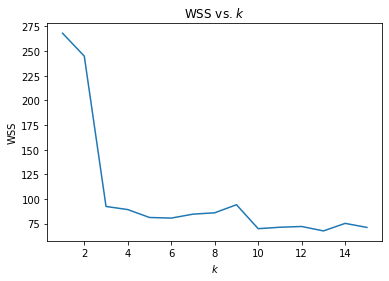

In [343]:
plt.plot(range(1, K_MAX+1), sse)
plt.title('WSS vs. $k$')
plt.xlabel('$k$')
plt.ylabel('WSS')
plt.show()

Based on the plot of *WSS vs. k*, it looks like there is an arm with a clear elbow at $k=4$.

The shape of the cluster centers: (4, 23, 1)


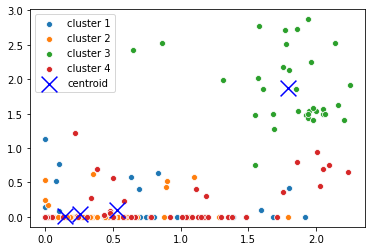

In [344]:
K = 4
kmeans = TimeSeriesKMeans(n_clusters=K, random_state=1)
clusters = kmeans.fit_predict(X)
num_clusters = kmeans.n_clusters
cluster_centers = kmeans.cluster_centers_

print('The shape of the cluster centers:', cluster_centers.shape)

for cluster_num in range(num_clusters):
    sns.scatterplot(
        x=X[clusters == cluster_num, 0], y=X[clusters == cluster_num, 1]
    )

plt.scatter(
    x=cluster_centers[:, 0], y=cluster_centers[:, 1],
    s=250, marker='x', c='blue'
)
plt.legend(['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'centroid'])
plt.show()

In [345]:
closest_points, _ = pairwise_distances_argmin_min(cluster_centers.reshape(4,23), X)
print('The closest points to each centroids are', closest_points)

The closest points to each centroids are [347 294  72   5]


In [346]:
closest_points_df = pd.DataFrame().reindex_like(data_df).iloc[0:0]

for closest_point in closest_points:
    gif = data_df.loc[[closest_point]]
    closest_points_df = closest_points_df.append(gif)

closest_points_df

,frame,face_id,timestamp,confidence,success,folder_path,pose_Tx,pose_Ty,pose_Tz,pose_Rx,pose_Ry,pose_Rz,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU45_c
347,3.0,0.0,0.400,0.98,1.0,./gifgif-happiness-features/data/682,-138.5,1.7,426.2,0.099,-0.071,-0.062,0.00,0.00,0.00,0.00,1.74,0.77,0.15,1.43,1.87,1.37,0.0,0.0,0.00,0.0,1.65,0.89,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
294,30.0,0.0,2.035,0.98,1.0,./gifgif-happiness-features/data/624,-33.6,23.3,267.4,0.203,0.108,0.049,0.00,0.00,0.27,0.00,2.39,2.35,0.55,1.54,2.62,1.05,0.0,0.0,0.00,0.0,2.13,0.00,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
72,6.0,0.0,0.300,0.93,1.0,./gifgif-happiness-features/data/831,-44.1,-13.2,339.1,0.043,0.223,-0.068,2.05,1.50,0.00,1.12,0.59,0.00,0.00,0.31,1.56,0.00,0.0,0.0,0.36,0.0,1.85,1.59,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
5,3.0,0.0,0.080,0.98,1.0,./gifgif-happiness-features/data/469,3.3,-9.4,419.2,0.081,-0.020,-0.011,0.48,0.06,0.00,0.24,0.28,0.88,0.05,0.00,0.86,0.50,0.0,0.0,0.53,0.0,0.80,0.47,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0


### 3.1. Social Signals

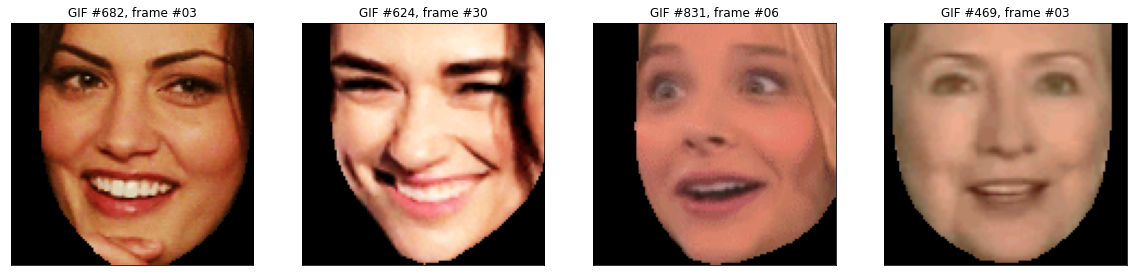

In [347]:
fig = plt.figure(figsize=(20, 20))
num_columns = 4
num_rows = 1
ax = []

for i, gif_folder_path in enumerate(closest_points_df['folder_path']):
    frame_num = '{:02d}'.format(int(closest_points_df.iloc[i]['frame']))
    gif_num = os.path.split(gif_folder_path)[1]
    frame_name = 'frame_det_00_0000' + frame_num + '.bmp'
    frames_folder_path = os.path.join(gif_folder_path, gif_num + '_aligned')
    frame_filepath = os.path.join(frames_folder_path, frame_name)
    image = mpimg.imread(frame_filepath)
    ax.append(fig.add_subplot(num_rows, num_columns, i+1))
    ax[-1].set_title('GIF #{}, frame #{}'.format(gif_num, frame_num))
    plt.imshow(image)
    plt.xticks(())
    plt.yticks(())

plt.show()

Based on a chosen GIF frame and the time series, it seems that each GIF image has the following social signals:

*   Social Signal #1, GIF #759: Eyes are wide open, and both jaw and lips are moving. The mouth is closed but lip corners are pulled up.
*   Social Signal #2, GIF #682: Cheeks are raised, lips are apart with the lip corners pulling up, and slowly rotating the head to the side.
*   Social Signal #3, GIF #624: Cheeks are raised, lips are apart with the lip corners pulling up, and a dimple is vividly visible.
*   Social Signal #4, GIF #469: The head is shaking, cheeks are raised, lips are apart with the lip corners pulling up.



## 4. Testing

As the final step, we choose Social Signal #3 (GIF #624) that we identified during our clustering process in Section 3, and create a training set of 24 GIF images (80%) and a test set of 6 GIF images (20%) with a total of 30 samples. Speaking of the samples, with and without the social signal samples are to be selected at a ratio of 1 to 1. Also, in order to test the performance, we create a dataset which includes confounding GIFs that are not our target social signal.

Using the dataset, we then use the k-nearest neighbours (_k_-NN) algorithm and _k_-fold cross validation to report the performance of _k_-NN classification and multidimensional DTW on our dataset.

### 4.1. New Dataset

In [348]:
# Filter by distinct `folder_path`.
df = data_df.drop_duplicates(subset=['folder_path'])

# Extract GIF #s (happiness ranks by scores) from `folder_path` and make a
# dedicated column for that.
df['rank'] = df['folder_path'].apply(lambda x: os.path.split(x)[1])

# Set `df['rank']` as the index of the DataFrame.
df = df.set_index('rank')

# Extract 40 random samples from the Series `df['folder_path']`. Note that we
# use `random_state` to ensure the reproducibility of the examples.
df['folder_path'].sample(n=40, random_state=0)

rank
244    ./gifgif-happiness-features/data/244
310    ./gifgif-happiness-features/data/310
469    ./gifgif-happiness-features/data/469
428    ./gifgif-happiness-features/data/428
555    ./gifgif-happiness-features/data/555
962    ./gifgif-happiness-features/data/962
986    ./gifgif-happiness-features/data/986
624    ./gifgif-happiness-features/data/624
906    ./gifgif-happiness-features/data/906
185    ./gifgif-happiness-features/data/185
759    ./gifgif-happiness-features/data/759
987    ./gifgif-happiness-features/data/987
706    ./gifgif-happiness-features/data/706
831    ./gifgif-happiness-features/data/831
788    ./gifgif-happiness-features/data/788
608    ./gifgif-happiness-features/data/608
63      ./gifgif-happiness-features/data/63
855    ./gifgif-happiness-features/data/855
559    ./gifgif-happiness-features/data/559
445    ./gifgif-happiness-features/data/445
25      ./gifgif-happiness-features/data/25
97      ./gifgif-happiness-features/data/97
782    ./gifgif-happiness-f

Going through the 40 GIFs one by one from top to bottom, we labeled each GIF as follows:

*   **Without** the social signal **(15 GIFs)**: 492, 572, 926, 19, 136, 782, 177, 881, 630, 63, 831, 24, 706, 47, 111
*   **With** the social signal **(10 GIFs)**: 192, 987, 730, 555, 200, 159, 651, 559, 369, 681
* Skipped social signal (because the without reached its allowance of 20 GIFs and is not the signal we want) **(15 GIFs)**: 445, 205, 491, 712, 202, 837, 602, 551, 962, 719, 775, 83, 194, 975, 840

Because we need 5 more GIFs _with_ the social signal, we repeat the process right above until we find the remaining GIFs.

_**NOTE:** This time, we use `random_state=1`. (Previously, it started with `random_state=0`.)_

In [349]:
# Extract another 40 random samples from the Series `df['folder_path']`. Note 
# that we use `random_state` to ensure the reproducibility of the examples.
df['folder_path'].sample(n=40, random_state=1)

rank
869    ./gifgif-happiness-features/data/869
886    ./gifgif-happiness-features/data/886
572    ./gifgif-happiness-features/data/572
712    ./gifgif-happiness-features/data/712
472    ./gifgif-happiness-features/data/472
316    ./gifgif-happiness-features/data/316
428    ./gifgif-happiness-features/data/428
271    ./gifgif-happiness-features/data/271
620    ./gifgif-happiness-features/data/620
759    ./gifgif-happiness-features/data/759
602    ./gifgif-happiness-features/data/602
775    ./gifgif-happiness-features/data/775
706    ./gifgif-happiness-features/data/706
185    ./gifgif-happiness-features/data/185
690    ./gifgif-happiness-features/data/690
346    ./gifgif-happiness-features/data/346
192    ./gifgif-happiness-features/data/192
730    ./gifgif-happiness-features/data/730
415    ./gifgif-happiness-features/data/415
651    ./gifgif-happiness-features/data/651
497    ./gifgif-happiness-features/data/497
573    ./gifgif-happiness-features/data/573
470    ./gifgif-happiness-f

*   **With** the social signal **(4 GIFs)**: 572, 730, 830, 668
* Skipped social signal (because the without reached its allowance of 20 GIFs and is not the signal we want) **(32 GIFs)**: 962, 692, 415, 620, 903, 291, 837, 853, 881, 906, 565, 63, 177, 357, 634, 838, 776, 452, 704, 185, 316, 111, 423, 759, 782, 274, 788, 346, 83, 310, 129, 202
* Duplicates from the _'with'_ **(4 GIFs)**: 559, 987, 159, 681

At this point, we have a total of 14 GIFs with the social signal. We need 1 more of them.

In [350]:
# Extract another 40 random samples from the Series `df['folder_path']`. Note 
# that we use `random_state` to ensure the reproducibility of the examples.
df['folder_path'].sample(n=40, random_state=2)

rank
775    ./gifgif-happiness-features/data/775
608    ./gifgif-happiness-features/data/608
565    ./gifgif-happiness-features/data/565
855    ./gifgif-happiness-features/data/855
986    ./gifgif-happiness-features/data/986
368    ./gifgif-happiness-features/data/368
469    ./gifgif-happiness-features/data/469
853    ./gifgif-happiness-features/data/853
630    ./gifgif-happiness-features/data/630
831    ./gifgif-happiness-features/data/831
602    ./gifgif-happiness-features/data/602
987    ./gifgif-happiness-features/data/987
19      ./gifgif-happiness-features/data/19
211    ./gifgif-happiness-features/data/211
704    ./gifgif-happiness-features/data/704
692    ./gifgif-happiness-features/data/692
782    ./gifgif-happiness-features/data/782
466    ./gifgif-happiness-features/data/466
573    ./gifgif-happiness-features/data/573
452    ./gifgif-happiness-features/data/452
837    ./gifgif-happiness-features/data/837
274    ./gifgif-happiness-features/data/274
346    ./gifgif-happiness-f

*   **With** the social signal **(1 GIF)**: 855 **STOP**
* Skipped social signal (because the without reached its allowance of 20 GIFs and is not the signal we want) **(6 GIFs)**: 565, 24, 47, 136, 49, 83
* Duplicates from the _'with'_ **(2 GIFs)**: 681, 987

We have found all the 15 GIFs with the social signal, and another 15 GIFs without the social signal.

*   **Without** the social signal **(15 GIFs)**: 492, 572, 926, 19, 136, 782, 177, 881, 630, 63, 831, 24, 706, 47, 111
*   **With** the social signal **(15 GIFs)**: 192, 987, 730, 555, 200, 159, 651, 559, 369, 681, 572, 730, 830, 668, 855

Let's label them in a new DataFrame `thirty_gif_df`.

In [351]:
WITH_GIF_LIST = ['192', '987', '730', '555', '200', 
                 '159', '651', '559', '369', '681', 
                 '572', '730', '830', '668', '855']

WITHOUT_GIF_LIST = ['492', '572', '926', '19', '136', 
                    '782', '177', '881', '630', '63', 
                    '831', '24', '706', '47', '111']

THIRTY_GIF_LIST = WITH_GIF_LIST + WITHOUT_GIF_LIST

# We get the raw data again from Section 2.2.1.
raw_data = pd.concat(df_list)

# Extract GIF #s (happiness ranks by scores) from `raw_data['folder_path']` and
# make a dedicated column for that.
raw_data['rank'] = raw_data['folder_path'].apply(lambda x: os.path.split(x)[1])

# Get the 30 GIF data.
thirty_gif_df = raw_data[raw_data['rank'].isin(THIRTY_GIF_LIST)]

# Label 15 GIFs 'with' the social signal.
thirty_gif_df.loc[
    thirty_gif_df['rank'].isin(WITH_GIF_LIST), 'is_social_signal'
] = 1

# Label 15 GIFs 'without' the social signal.
thirty_gif_df.loc[
    thirty_gif_df['rank'].isin(WITHOUT_GIF_LIST), 'is_social_signal'
] = 0

thirty_gif_df

,frame,face_id,timestamp,confidence,success,folder_path,pose_Tx,pose_Ty,pose_Tz,pose_Rx,pose_Ry,pose_Rz,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU45_c,rank,is_social_signal
0,1,0,0.0,0.98,1,./gifgif-happiness-features/data/159,-14.4,-38.0,329.7,0.039,-0.216,-0.095,1.47,0.82,0.92,0.00,1.52,0.61,0.18,1.38,2.44,0.12,0.00,0.00,0.00,0.00,1.91,1.06,0.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,159,1.0
1,2,0,0.1,0.98,1,./gifgif-happiness-features/data/159,-16.7,-37.2,333.3,0.064,-0.199,-0.133,0.68,0.36,1.02,0.00,1.49,0.79,0.16,1.46,2.54,0.16,0.00,0.00,0.00,0.00,1.94,0.79,0.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,159,1.0
2,3,0,0.2,0.98,1,./gifgif-happiness-features/data/159,-20.6,-35.8,332.7,0.071,-0.173,-0.135,0.69,0.40,0.78,0.00,1.56,1.09,0.09,1.06,2.29,0.00,0.00,0.00,0.00,0.00,1.93,0.68,0.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,159,1.0
3,4,0,0.3,0.98,1,./gifgif-happiness-features/data/159,-23.6,-34.9,331.9,0.066,-0.172,-0.118,0.75,0.54,0.44,0.00,1.63,0.29,0.25,1.11,2.53,0.33,0.00,0.00,0.00,0.00,1.85,0.56,0.00,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,159,1.0
4,5,0,0.4,0.98,1,./gifgif-happiness-features/data/159,-25.6,-35.2,332.3,0.067,-0.175,-0.114,1.34,0.85,1.04,0.00,1.54,1.12,0.00,1.41,2.68,0.49,0.00,0.00,0.00,0.00,1.97,0.52,0.00,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,159,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,11,0,2.0,0.93,1,./gifgif-happiness-features/data/706,37.6,-21.2,585.9,0.080,0.315,0.059,0.00,0.00,0.00,0.00,1.73,2.06,1.25,1.54,2.63,1.95,0.00,0.00,0.00,0.00,2.49,0.02,0.39,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,706,0.0
11,12,0,2.2,0.93,1,./gifgif-happiness-features/data/706,32.8,-18.3,588.7,0.152,0.252,0.043,0.00,0.00,0.00,0.00,1.83,2.26,1.75,1.95,2.81,2.36,0.00,0.08,0.06,0.00,2.53,0.10,0.38,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,706,0.0
12,13,0,2.4,0.43,0,./gifgif-happiness-features/data/706,31.7,-18.3,585.7,0.125,0.237,0.055,0.00,0.00,0.00,0.00,1.46,0.00,0.11,0.16,1.72,0.81,0.00,0.44,0.53,0.00,0.94,0.00,0.00,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,706,0.0
13,14,0,2.6,0.22,0,./gifgif-happiness-features/data/706,28.5,-16.3,577.2,0.170,0.180,0.081,0.37,0.00,0.00,0.79,0.91,0.00,0.00,0.72,0.82,0.00,0.41,0.94,1.20,0.66,0.00,0.00,0.00,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,706,0.0


Finally, the dataset of 30 GIFs needs to be split into a training set (80%) with 24 GIFs, and a test set (20%) with 6 GIFs. We use _k_-fold cross-validation with $k=5$ to achieve that in the next subsection.

### 4.2. _k_-Fold Cross-Validation and _k_-Nearest Neighbours Classification

For cross-validation, we use $k=5$, such that it is 5-fold cross-validation.

Scale all the Pose feature values into the range [0,5], just like how it was done in Section 2.2.2.

In [352]:
def scale_pose_series(pose_col):
    """Scales a Pose Series (column) to bring all values into the range [0,5].

    Args:
        pose_col: The Pose Series (column) to apply the scaling.

    Returns:
        A new scaled Pose Series.
    """
    return ((pose_col - pose_col.min()) / (pose_col.max() - pose_col.min())) * 5

thirty_gif_df['pose_Tx'] = scale_pose_series(thirty_gif_df['pose_Tx'])
thirty_gif_df['pose_Ty'] = scale_pose_series(thirty_gif_df['pose_Ty'])
thirty_gif_df['pose_Tz'] = scale_pose_series(thirty_gif_df['pose_Tz'])
thirty_gif_df['pose_Rx'] = scale_pose_series(thirty_gif_df['pose_Rx'])
thirty_gif_df['pose_Ry'] = scale_pose_series(thirty_gif_df['pose_Ry'])
thirty_gif_df['pose_Rz'] = scale_pose_series(thirty_gif_df['pose_Rz'])

thirty_gif_df

,frame,face_id,timestamp,confidence,success,folder_path,pose_Tx,pose_Ty,pose_Tz,pose_Rx,pose_Ry,pose_Rz,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU45_c,rank,is_social_signal
0,1,0,0.0,0.98,1,./gifgif-happiness-features/data/159,3.425113,3.840883,1.082995,2.111826,1.958162,1.612903,1.47,0.82,0.92,0.00,1.52,0.61,0.18,1.38,2.44,0.12,0.00,0.00,0.00,0.00,1.91,1.06,0.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,159,1.0
1,2,0,0.1,0.98,1,./gifgif-happiness-features/data/159,3.394520,3.856110,1.108229,2.212389,2.016461,1.401557,0.68,0.36,1.02,0.00,1.49,0.79,0.16,1.46,2.54,0.16,0.00,0.00,0.00,0.00,1.94,0.79,0.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,159,1.0
2,3,0,0.2,0.98,1,./gifgif-happiness-features/data/159,3.342644,3.882756,1.104024,2.240547,2.105624,1.390434,0.69,0.40,0.78,0.00,1.56,1.09,0.09,1.06,2.29,0.00,0.00,0.00,0.00,0.00,1.93,0.68,0.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,159,1.0
3,4,0,0.3,0.98,1,./gifgif-happiness-features/data/159,3.302740,3.899886,1.098416,2.220434,2.109053,1.484983,0.75,0.54,0.44,0.00,1.63,0.29,0.25,1.11,2.53,0.33,0.00,0.00,0.00,0.00,1.85,0.56,0.00,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,159,1.0
4,5,0,0.4,0.98,1,./gifgif-happiness-features/data/159,3.276137,3.894176,1.101220,2.224457,2.098765,1.507230,1.34,0.85,1.04,0.00,1.54,1.12,0.00,1.41,2.68,0.49,0.00,0.00,0.00,0.00,1.97,0.52,0.00,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,159,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,11,0,2.0,0.93,1,./gifgif-happiness-features/data/706,4.116786,4.160640,2.878873,2.276750,3.779150,2.469410,0.00,0.00,0.00,0.00,1.73,2.06,1.25,1.54,2.63,1.95,0.00,0.00,0.00,0.00,2.49,0.02,0.39,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,706,0.0
11,12,0,2.2,0.93,1,./gifgif-happiness-features/data/706,4.052940,4.215836,2.898500,2.566372,3.563100,2.380423,0.00,0.00,0.00,0.00,1.83,2.26,1.75,1.95,2.81,2.36,0.00,0.08,0.06,0.00,2.53,0.10,0.38,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,706,0.0
12,13,0,2.4,0.43,0,./gifgif-happiness-features/data/706,4.038308,4.215836,2.877471,2.457763,3.511660,2.447164,0.00,0.00,0.00,0.00,1.46,0.00,0.11,0.16,1.72,0.81,0.00,0.44,0.53,0.00,0.94,0.00,0.00,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,706,0.0
13,14,0,2.6,0.22,0,./gifgif-happiness-features/data/706,3.995744,4.253902,2.817889,2.638777,3.316187,2.591769,0.37,0.00,0.00,0.79,0.91,0.00,0.00,0.72,0.82,0.00,0.41,0.94,1.20,0.66,0.00,0.00,0.00,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,706,0.0


We preprocess the data for k-NN classficiation, one last time.

In [353]:
thirty_gif_df = preprocess_df(thirty_gif_df)
thirty_gif_df

,frame,face_id,timestamp,confidence,success,folder_path,pose_Tx,pose_Ty,pose_Tz,pose_Rx,pose_Ry,pose_Rz,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU45_c,rank,is_social_signal
0,3,0,0.200,0.98,1,./gifgif-happiness-features/data/159,3.342644,3.882756,1.104024,2.240547,2.105624,1.390434,0.69,0.40,0.78,0.0,1.56,1.09,0.09,1.06,2.29,0.00,0.0,0.0,0.0,0.0,1.93,0.68,0.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,159,1.0
1,13,0,1.200,0.98,1,./gifgif-happiness-features/data/159,3.277467,3.762847,1.090705,2.280772,2.146776,1.351502,0.63,0.58,1.00,0.0,1.93,0.82,0.00,1.17,2.90,0.91,0.0,0.0,0.0,0.0,2.13,0.20,0.00,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,159,1.0
2,4,0,0.537,0.98,1,./gifgif-happiness-features/data/782,2.629689,4.154930,2.045423,2.618665,1.920439,1.751947,0.28,0.00,0.00,0.0,2.60,0.00,0.45,3.08,3.39,2.47,0.0,0.0,0.0,0.0,2.57,0.00,0.44,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,782,0.0
3,5,0,0.716,0.98,1,./gifgif-happiness-features/data/782,2.593775,4.133993,2.051731,2.638777,1.903292,1.629588,0.25,0.00,0.00,0.0,2.49,0.00,0.31,2.73,3.28,2.23,0.0,0.0,0.0,0.0,2.43,0.00,0.00,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,782,0.0
4,6,0,0.896,0.98,1,./gifgif-happiness-features/data/782,2.548550,4.114960,2.060844,2.594529,1.910151,1.535039,0.44,0.00,0.00,0.0,2.04,0.00,0.30,2.92,2.99,2.44,0.0,0.0,0.0,0.0,2.03,0.00,0.00,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,782,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,13,0,1.200,0.98,1,./gifgif-happiness-features/data/651,2.255919,4.200609,1.404739,2.767498,3.216735,2.641824,0.09,0.00,0.00,0.0,0.98,2.20,0.00,1.13,2.11,0.30,0.0,0.0,0.0,0.0,1.46,1.17,0.00,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,651,1.0
72,14,0,1.300,0.98,1,./gifgif-happiness-features/data/651,2.301144,4.225352,1.394925,2.614642,3.257888,2.753059,0.13,0.00,0.00,0.0,0.74,1.88,0.00,0.75,1.87,0.75,0.0,0.0,0.0,0.0,1.39,1.51,0.00,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,651,1.0
73,10,0,0.900,0.98,1,./gifgif-happiness-features/data/987,3.574089,3.149981,2.754802,3.825422,2.565158,2.647386,0.00,0.00,0.00,0.0,2.38,3.00,1.32,2.67,3.12,1.25,0.0,0.0,0.0,0.0,2.48,0.71,0.55,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,987,1.0
74,2,0,0.200,0.98,1,./gifgif-happiness-features/data/706,4.058260,4.004568,2.765316,2.932422,1.903292,2.358176,0.00,0.00,0.00,0.0,1.25,2.50,1.60,1.62,2.17,0.33,0.0,0.0,0.0,0.0,2.11,0.00,0.06,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,706,0.0


We split the dataset of 30 GIFs needs into a training set (80%) with 24 GIFs, and a test set (20%) with 6 GIFs. Note that there are 76 frames of the 30 GIFs.

In [354]:
features = list(thirty_gif_df.columns)

# Get AU intensity columns only for k-NN classification.
filtered = fnmatch.filter(features, 'AU??_r')
filtered += fnmatch.filter(features, 'pose*')
# filtered += fnmatch.filter(features, 'rank')
# filtered += fnmatch.filter(features, 'is_social_signal')

X = thirty_gif_df[filtered]
y = thirty_gif_df['is_social_signal']

# Split the dataset into train (80%) and test (20%) subsets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

print('# of X_train data:', len(X_train))
print('# of X_test data:', len(X_test))
print('# of y_train data:', len(y_train))
print('# of y_test data:', len(y_test))

# of X_train data: 60
# of X_test data: 16
# of y_train data: 60
# of y_test data: 16


In [355]:
# Create a new k-NN model with k = 1.
knn_cv = KNeighborsClassifier(n_neighbors=1)

# Examine k-NN alone.
knn_cv.fit(X_train, y_train)
y_pred = knn_cv.predict(X_test)
print('k-NN Accuracy (without Cross-Validation):', knn_cv.score(X_test, y_test))

# Train model with a cross-validation (CV) generator with 5 folds. Note: the 
# CV generator uses `sklearn.model_selection.StratifiedKFold`.
cv_scores = cross_val_score(knn_cv, X, y, cv=5)

print('Cross-Validation Scores:', cv_scores)
print('Mean Cross-Validation Score:{}'.format(np.mean(cv_scores)))

k-NN Accuracy (without Cross-Validation): 0.8125
Cross-Validation Scores: [0.5625     0.73333333 0.2        0.46666667 0.46666667]
Mean Cross-Validation Score:0.48583333333333334
